# Introduction
Below we are doing in-depth analysis of Oscars data to find meaningful insights. We'll try to answer list of questions by doing various analysis of data. 

Below are list of questions which we'll try to answer while doing data analysis:
1. Can we come up with a model that could predict the winner among the nominees? Or determine their success factors?  Has there been a change over time, is there an obvious pattern? (The trend of some notable groups?)
Or in more detail: 

2. Do IMDB ratings ( audience taste) agree with the academy members opinion?

3. Does budget necessarily play an important role?

4. Does diversity or lack of diversity of cast and crew in terms of race, gender, sexual orientation, etc. show a pattern of some sort? 

5. What movie genre and categories are more likely to win the award?


We'll be taking into consideration `Actors, Actresses and Directors` data collected over years for our analysis purpose.

In [159]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, log_loss, classification_report

from collections import Counter
import warnings
import copy
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 30)

%matplotlib inline

# Data Loading Cleaning and Preparation
It involves list of steps to be performed to prepare data for various tasks:
* Loading Datasets
* Handling data types like float, int, strings
* Cleaning data to handle NA entries.
* Merging data from various sources to create bigger data frames for analysis

### 1. Loading Dataset of Nominations & Winners together
Below we are loading dataset which has information about nominations for Actors, Actress and Directors for all years along with winner information as well. It contains information about movie to which they belong as well.

Also original dataset has film and winner data was swapped after particular entry hence there is code below to correct that part as well.

**Data Source:** https://www.kaggle.com/theacademy/academy-awards

In [160]:
main_df = pd.read_csv('database.csv')
award_categories = ['Actor', 'Actress', 'Directing']#, 'Directing (Comedy Picture)', 'Directing (Dramatic Picture)', 'Documentary']

actor_nomination = main_df[main_df.Award == 'Actor']
actress_nomination = main_df[main_df.Award == 'Actress']
directing_nomination = main_df[main_df.Award == 'Directing']

## Below code is responsible for lining up Film and Winners. Column Film and Winners data seems to have been flipped 
## after cimarron entry.
names, films = [], []
cimarron_detected = False
for name,film in zip(directing_nomination.Name, directing_nomination.Film):
    if name == 'Cimarron ':
        cimarron_detected = True
    if cimarron_detected:
        names.append(film)
        films.append(name)
    else:
        names.append(name)
        films.append(film)
directing_nomination['Name'] = names
directing_nomination['Film'] = films

#print(actor_nomination.shape[0]+actress_nomination.shape[0]+directing_nomination.shape[0])
main_df = pd.concat([actor_nomination, actress_nomination, directing_nomination])
main_df = main_df.drop(['Ceremony'], axis=1)
main_df['Film'] = main_df.Film.str.strip()
main_df['Winner'] = main_df['Winner'].fillna(0)

print('Total Data Size : ',main_df.shape)
main_df.head()

Total Data Size :  (897, 5)


,Year,Award,Winner,Name,Film
0,1927/1928,Actor,0.0,Richard Barthelmess,The Noose
1,1927/1928,Actor,1.0,Emil Jannings,The Last Command
35,1928/1929,Actor,0.0,George Bancroft,Thunderbolt
36,1928/1929,Actor,1.0,Warner Baxter,In Old Arizona
37,1928/1929,Actor,0.0,Chester Morris,Alibi


### Loading Winning Actors Data
Below we are loading winning actors and their movies data. It also contains information about movie duration, num of nominations in that year and genres data as well.

**Data Source:** https://cs.uwaterloo.ca/~s255khan/oscars.html

In [161]:
winning_actors = pd.read_csv('actors.csv')
winning_actors['name'] = winning_actors.name.str.strip()
winning_actors = winning_actors.drop(['synopsis'], axis=1)
print('Winning Actors Size : ',winning_actors.shape)
winning_actors.head()

Winning Actors Size :  (87, 9)


,name,year,nominations,rating,duration,genre1,genre2,release,metacritic
0,The Theory of Everything,2014,5,7.7,123,Biography,Drama,January,72.0
1,Dallas Buyers Club,2013,6,8.0,117,Biography,Drama,November,84.0
2,Lincoln,2012,12,7.4,150,Biography,Drama,November,86.0
3,The Artist,2011,10,8.0,100,Comedy,Drama,October,89.0
4,The King's Speech,2010,12,8.0,118,Biography,Drama,December,88.0


### Loading Winning Actress Data
Below we are loading winning actress and their movies data. It also contains information about movie duration, num of nominations in that year and genres data as well.

**Data Source:** https://cs.uwaterloo.ca/~s255khan/oscars.html

In [162]:
winning_actresses = pd.read_csv('actresses.csv')
winning_actresses['name'] = winning_actresses.name.str.strip()
winning_actresses = winning_actresses.drop(['synopsis'], axis=1)
print('Winning Actresses Size : ',winning_actresses.shape)
winning_actresses.head()

Winning Actresses Size :  (87, 9)


,name,year,nominations,rating,duration,genre1,genre2,release,metacritic
0,Still Alice,2014,NaN,7.5,101,Drama,NaN,February,72.0
1,Blue Jasmine,2013,3,7.3,98,Drama,NaN,August,78.0
2,Silver Linings Playbook,2012,8,7.8,122,Comedy,Drama,November,81.0
3,The Iron Lady,2011,2,6.4,105,Biography,Drama,January,54.0
4,Black Swan,2010,5,8.0,108,Drama,Thriller,December,79.0


### Loading Winning Directors Data
Below we are loading winning directors and their movies data. It also contains information about movie duration, num of nominations in that year and genres data as well.

**Data Source:** https://cs.uwaterloo.ca/~s255khan/oscars.html

In [163]:
winning_directors = pd.read_csv('directors.csv')
winning_directors['name'] = winning_directors.name.str.strip()
winning_directors = winning_directors.drop(['synopsis'], axis=1)
print('Winning Directors Size : ',winning_directors.shape)
winning_directors.head()

Winning Directors Size :  (86, 9)


,name,year,nominations,rating,duration,genre1,genre2,release,metacritic
0,Birdman,2014,9,7.8,119,Comedy,Drama,November,88.0
1,Gravity,2013,10,7.9,91,Sci-Fi,Thriller,October,96.0
2,Life of Pi,2012,11,8.0,127,Adventure,Drama,November,79.0
3,The Artist,2011,10,8.0,100,Comedy,Drama,October,89.0
4,The King's Speech,2010,12,8.0,118,Biography,Drama,December,88.0


### Loading Winning Movies Data
Below we are loading winning movies data. It also contains information about movie duration, num of nominations in that year and genres data as well.

**Data Source :** https://cs.uwaterloo.ca/~s255khan/oscars.html

In [164]:
winning_movies = pd.read_csv('pictures.csv')
winning_movies['name'] = winning_movies.name.str.strip()
winning_movies = winning_movies.drop(['synopsis'], axis=1)
print('Winning Movies Size : ',winning_movies.shape)
winning_movies.head()

Winning Movies Size :  (87, 9)


,name,year,nominations,rating,duration,genre1,genre2,release,metacritic
0,Birdman,2014,9,7.8,119,Comedy,Drama,November,88.0
1,12 Years a Slave,2013,9,8.1,134,Biography,Drama,November,97.0
2,Argo,2012,7,7.8,120,Biography,Drama,October,86.0
3,The Artist,2011,10,8.0,100,Comedy,Drama,October,89.0
4,The King's Speech,2010,12,8.0,118,Biography,Drama,December,88.0


### Demographics Data
Below we are loading demographics dataset which has information about Oscar award winners actors, directors, actresses birthplace, ethnicity, religion and sexual orientation data.

**Data Source :** https://data.world/crowdflower/academy-awards-demographics

In [165]:
demographics_data = pd.read_csv('Oscars-demographics-DFE.csv', encoding='latin1')
#print(demographics_data.columns)
cols = ['award','movie','person','birthplace','date_of_birth','race_ethnicity','religion','sexual_orientation']
demographics_data = demographics_data[cols]
demographics_data['movie'] = demographics_data.movie.str.strip()
print('Demographics Data : ', demographics_data.shape)
demographics_data.head()

Demographics Data :  (441, 8)


,award,movie,person,birthplace,date_of_birth,race_ethnicity,religion,sexual_orientation
0,Best Director,Two Arabian Knights,Lewis Milestone,"Chisinau, Moldova",30-Sep-1895,White,Na,Straight
1,Best Director,The Divine Lady,Frank Lloyd,"Glasgow, Scotland",2-Feb-1886,White,Na,Straight
2,Best Director,All Quiet on the Western Front,Lewis Milestone,"Chisinau, Moldova",30-Sep-1895,White,Na,Straight
3,Best Director,Skippy,Norman Taurog,"Chicago, Il",23-Feb-1899,White,Na,Straight
4,Best Director,Bad Girl,Frank Borzage,"Salt Lake City, Ut",23-Apr-1894,White,Roman Catholic,Straight


In [166]:
demographics_data['award'].unique()

array(['Best Director', 'Best Actor', 'Best Supporting Actor',
       'Best Actress', 'Best Supporting Actress'], dtype=object)

### Loading Movies Metadata
Below we are loading movies metadata which has information about movies budget, gross income, imdb score, genres etc.

**Data Source :** https://data.world/popculture/imdb-5000-movie-dataset

In [167]:
metadata = pd.read_csv('movie_metadata.csv')
#print(metadata.columns)
cols = ['movie_title', 'budget', 'gross']
cols2 = ['movie_title', 'budget', 'gross', 'duration', 'genres', 'imdb_score']
#metadata = metadata[cols2]
metadata['movie_title'] = metadata.movie_title.str.strip()
print('Metadata Size : ',metadata.shape)
metadata.head()

Metadata Size :  (5043, 28)


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,11700,Stephanie Sigman,1.0,bomb|espionage|sequel|spy|terrorist,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.0,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,Doug Walker,Star Wars: Episode VII - The Force Awakens,8,143,NaN,0.0,NaN,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


### Merging Winning Actors with Movie Metadata
Below we are merging movies metadata with winning actors data to get information about budget, gross income of movies etc.

Please notice that data about budget and gross income is added to dataframe.

In [168]:
winning_actors = winning_actors.merge(metadata[cols], how='left', left_on='name', right_on='movie_title').drop(['movie_title'], axis=1)
winning_actors.head()

,name,year,nominations,rating,duration,genre1,genre2,release,metacritic,budget,gross
0,The Theory of Everything,2014,5,7.7,123,Biography,Drama,January,72.0,15000000.0,35887263.0
1,Dallas Buyers Club,2013,6,8.0,117,Biography,Drama,November,84.0,5000000.0,27296514.0
2,Lincoln,2012,12,7.4,150,Biography,Drama,November,86.0,65000000.0,182204440.0
3,The Artist,2011,10,8.0,100,Comedy,Drama,October,89.0,15000000.0,44667095.0
4,The King's Speech,2010,12,8.0,118,Biography,Drama,December,88.0,15000000.0,138795342.0


### Merging Winning Actress with Movie Metadata
Below we are merging metadata with winning actress data to get information about budget, gross income of movies etc.

Please notice that data about budget and gross income is added to dataframe.

In [169]:
winning_actresses = winning_actresses.merge(metadata[cols], how='left', left_on='name', right_on='movie_title').drop(['movie_title'], axis=1)
winning_actresses.head()

,name,year,nominations,rating,duration,genre1,genre2,release,metacritic,budget,gross
0,Still Alice,2014,NaN,7.5,101,Drama,NaN,February,72.0,5000000.0,18656400.0
1,Blue Jasmine,2013,3,7.3,98,Drama,NaN,August,78.0,18000000.0,33404871.0
2,Silver Linings Playbook,2012,8,7.8,122,Comedy,Drama,November,81.0,21000000.0,132088910.0
3,The Iron Lady,2011,2,6.4,105,Biography,Drama,January,54.0,13000000.0,29959436.0
4,Black Swan,2010,5,8.0,108,Drama,Thriller,December,79.0,13000000.0,106952327.0


### Merging Winning Directors with Movie Metadata
Below we are merging metadata with winning directors data to get information about budget, gross income of movies etc.

Please notice that data about budget and gross income is added to dataframe.

In [170]:
winning_directors = winning_directors.merge(metadata[cols], how='left', left_on='name', right_on='movie_title').drop(['movie_title'], axis=1)
winning_directors.head()

,name,year,nominations,rating,duration,genre1,genre2,release,metacritic,budget,gross
0,Birdman,2014,9,7.8,119,Comedy,Drama,November,88.0,NaN,NaN
1,Gravity,2013,10,7.9,91,Sci-Fi,Thriller,October,96.0,100000000.0,274084951.0
2,Life of Pi,2012,11,8.0,127,Adventure,Drama,November,79.0,120000000.0,124976634.0
3,The Artist,2011,10,8.0,100,Comedy,Drama,October,89.0,15000000.0,44667095.0
4,The King's Speech,2010,12,8.0,118,Biography,Drama,December,88.0,15000000.0,138795342.0


### Merging Winning Movies with Movie Metadata
Below we are merging metadata with winning movies data to get information about budget, gross income of movies etc.

Please notice that data about budget and gross income is added to dataframe.

In [171]:
winning_movies = winning_movies.merge(metadata[cols], how='left', left_on='name', right_on='movie_title').drop(['movie_title'], axis=1)
winning_movies.head()

,name,year,nominations,rating,duration,genre1,genre2,release,metacritic,budget,gross
0,Birdman,2014,9,7.8,119,Comedy,Drama,November,88.0,NaN,NaN
1,12 Years a Slave,2013,9,8.1,134,Biography,Drama,November,97.0,20000000.0,56667870.0
2,Argo,2012,7,7.8,120,Biography,Drama,October,86.0,44500000.0,136019448.0
3,The Artist,2011,10,8.0,100,Comedy,Drama,October,89.0,15000000.0,44667095.0
4,The King's Speech,2010,12,8.0,118,Biography,Drama,December,88.0,15000000.0,138795342.0


### Merging Winning Actors with Demographics Data
Below we are merging demographics data with winning actors data to get information about birthplace, ethnicity, religion, sexual orientation etc.

Please note that information about birthplace, date of birth, race , religion, sexual orientation are added.

In [172]:
winning_actors = winning_actors.merge(demographics_data[demographics_data.award == 'Best Actor'], how='left',  left_on='name',  right_on='movie').drop(['movie', 'award'], axis=1)
winning_actors.head()

,name,year,nominations,rating,duration,genre1,genre2,release,metacritic,budget,gross,person,birthplace,date_of_birth,race_ethnicity,religion,sexual_orientation
0,The Theory of Everything,2014,5,7.7,123,Biography,Drama,January,72.0,15000000.0,35887263.0,NaN,NaN,NaN,NaN,NaN,NaN
1,Dallas Buyers Club,2013,6,8.0,117,Biography,Drama,November,84.0,5000000.0,27296514.0,Matthew McConaughey,"Uvalde, Tx",4-Nov-69,White,Na,Straight
2,Lincoln,2012,12,7.4,150,Biography,Drama,November,86.0,65000000.0,182204440.0,Daniel Day-Lewis,"London, England",29-Apr-57,White,Na,Straight
3,The Artist,2011,10,8.0,100,Comedy,Drama,October,89.0,15000000.0,44667095.0,Jean Dujardin,"Rueil-Malmaison, Hauts-De-Seine, France",19-Jun-72,White,Na,Straight
4,The King's Speech,2010,12,8.0,118,Biography,Drama,December,88.0,15000000.0,138795342.0,Colin Firth,"Grayshott, Hampshire, England",10-Sep-60,White,Na,Straight


### Merging Winning Actress with Demographics Data
Below we are merging demographics data with winning actress data to get information about birthplace, ethnicity, religion, sexual orientation etc.

Please note that information about birthplace, date of birth, race , religion, sexual orientation are added.

In [173]:
winning_actresses = winning_actresses.merge(demographics_data[demographics_data.award == 'Best Actress'], how='left',  left_on='name',  right_on='movie').drop(['movie', 'award'], axis=1)
winning_actresses.head()

,name,year,nominations,rating,duration,genre1,genre2,release,metacritic,budget,gross,person,birthplace,date_of_birth,race_ethnicity,religion,sexual_orientation
0,Still Alice,2014,NaN,7.5,101,Drama,NaN,February,72.0,5000000.0,18656400.0,NaN,NaN,NaN,NaN,NaN,NaN
1,Blue Jasmine,2013,3,7.3,98,Drama,NaN,August,78.0,18000000.0,33404871.0,Cate Blanchett,"Melbourne, Victoria, Australia",14-May-69,White,Na,Straight
2,Silver Linings Playbook,2012,8,7.8,122,Comedy,Drama,November,81.0,21000000.0,132088910.0,Jennifer Lawrence,"Louisville, Ky",15-Aug-90,White,Na,Na
3,The Iron Lady,2011,2,6.4,105,Biography,Drama,January,54.0,13000000.0,29959436.0,Meryl Streep,"Summit, Nj",22-Jun-49,White,Na,Straight
4,Black Swan,2010,5,8.0,108,Drama,Thriller,December,79.0,13000000.0,106952327.0,Natalie Portman,"Jerusalem, Israel",9-Jun-81,White,Jewish,Straight


### Merging Winning Directors with Demographics Data
Below we are merging demographics data with winning directors data to get information about birthplace, ethnicity, religion, sexual orientation etc.

Please note that information about birthplace, date of birth, race , religion, sexual orientation are added.

In [174]:
winning_directors = winning_directors.merge(demographics_data[demographics_data.award == 'Best Director'], how='left',  left_on='name',  right_on='movie').drop(['movie', 'award'], axis=1)
winning_directors.head()

,name,year,nominations,rating,duration,genre1,genre2,release,metacritic,budget,gross,person,birthplace,date_of_birth,race_ethnicity,religion,sexual_orientation
0,Birdman,2014,9,7.8,119,Comedy,Drama,November,88.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Gravity,2013,10,7.9,91,Sci-Fi,Thriller,October,96.0,100000000.0,274084951.0,NaN,NaN,NaN,NaN,NaN,NaN
2,Life of Pi,2012,11,8.0,127,Adventure,Drama,November,79.0,120000000.0,124976634.0,Ang Lee,"Pingtung, Taiwan",23-Oct-54,Asian,Na,Straight
3,The Artist,2011,10,8.0,100,Comedy,Drama,October,89.0,15000000.0,44667095.0,Michel Hazanavicius,"Paris, France",29-Mar-67,White,Jewish,Straight
4,The King's Speech,2010,12,8.0,118,Biography,Drama,December,88.0,15000000.0,138795342.0,Tom Hooper,"London, England",1972,White,Na,Na


### Merging Nomination & Winners Data with Movies Metadata and Demographics Data
Below we are adding demographics and movies metadata to dataframe with have information about nominations along with winners per year.

Please note that information about birthplace, date of birth, race , religion, sexual orientation are added.

**Note:** This dataframe will be used for machine learning hence we combined all data.

In [175]:
main_df = main_df.merge(metadata[cols2], how='left', left_on='Film', right_on='movie_title').drop(['movie_title'], axis=1)
main_df = main_df.merge(demographics_data, how='left', left_on='Film', right_on='movie').drop(['movie', 'award'],axis=1)
main_df.head()

,Year,Award,Winner,Name,Film,budget,gross,duration,genres,imdb_score,person,birthplace,date_of_birth,race_ethnicity,religion,sexual_orientation
0,1927/1928,Actor,0.0,Richard Barthelmess,The Noose,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1927/1928,Actor,1.0,Emil Jannings,The Last Command,NaN,NaN,NaN,NaN,NaN,Emil Jannings,"Rorschach, Switzerland",23-Jul-1884,White,Na,Bisexual
2,1928/1929,Actor,0.0,George Bancroft,Thunderbolt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1928/1929,Actor,1.0,Warner Baxter,In Old Arizona,NaN,NaN,NaN,NaN,NaN,Warner Baxter,"Columbus, Oh",29-Mar-1889,White,Na,Straight
4,1928/1929,Actor,0.0,Chester Morris,Alibi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Questions of Interest
## 1. Can we come up with a model that could predict the winner among the nominees? Or determine their success factors?

### Data preparation for ML Model
Below we are creating dataframe for machine leaning model. We'll be trying Random Forest machine learning model which given input will predict whether entry will win award or not. Below are list of steps which needs to be performed to make data ready for ML Models:
* Converting all data to float (We need all entries to be float for ML models)
* Converting all categorical columns to one hot encoded like genres, awards, ethnicity, religion, sexual orientation etc. (For categorical columns, we need to one-hot encoded that columns.)
* Taking care of missing values (Replacing by average as of now)

In [176]:
## One Hot Encoding part for Genres.
## One hot encoding refers to creating one entry for particular value of column.
## Hence ll genre will be one column in dataframe and it'll have value of 1 if that genre is present for movie
## else value will be 0.
## So if movie is action/animation then column for action and animation will have 1 entry and all other columns will
## have 0 in it.

genres_cols = ['Action','Adventure','Animation','Biography','Comedy','Crime','Drama','Family','Fantasy','Film-Noir','History',
 'Horror','Music','Musical','Mystery','Romance','Sci-Fi','Sport','Thriller','War','Western']

genres_data = []

## Below logic loops through all rows of dataframe and for each movie whichever genres are present
## that generas will have 1 as entry and all other generes which are not part of movie will have 0.
## Example : generes = Action | Adventure | War then entry for that row genres will be like [1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]

for g1 in main_df.genres: ## Looping through genres. Check values of genres in main_df dataframe above to get idea.
    if isinstance(g1, str):
        g_row = []
        for g2 in genres_cols:
            if g2 in g1:
                g_row.append(1) ## If genre is present for movie then 1 is added else 0 is added.
            else:
                g_row.append(0)
        genres_data.append(g_row)
    else:
        genres_data.append([0] * len(genres_cols))

genres_data = np.array(genres_data)

ml_df = main_df.copy() ## Creating duplicate dataframe whose values will be used as input to ML Model.
for i, col in enumerate(genres_cols):
    ml_df[col] = genres_data[:,i] ### Putting Individual Generes data in dataframe.
    
ml_df.head()

,Year,Award,Winner,Name,Film,budget,gross,duration,genres,imdb_score,person,birthplace,date_of_birth,race_ethnicity,religion,...,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,1927/1928,Actor,0.0,Richard Barthelmess,The Noose,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1927/1928,Actor,1.0,Emil Jannings,The Last Command,NaN,NaN,NaN,NaN,NaN,Emil Jannings,"Rorschach, Switzerland",23-Jul-1884,White,Na,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1928/1929,Actor,0.0,George Bancroft,Thunderbolt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1928/1929,Actor,1.0,Warner Baxter,In Old Arizona,NaN,NaN,NaN,NaN,NaN,Warner Baxter,"Columbus, Oh",29-Mar-1889,White,Na,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1928/1929,Actor,0.0,Chester Morris,Alibi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [177]:
## Please make a note that we are making below changes because ML model can not handle NA values and all values should be present.

ml_df['race_ethnicity'] = ml_df['race_ethnicity'].fillna('Na') ## Filling NA for rows where race is not present.
ml_df['religion'] = ml_df['religion'].fillna('Na') ## Filling NA for rows where religion is not present.
ml_df['sexual_orientation'] = ml_df['sexual_orientation'].fillna('Na') ## Filling NA for rows where sexual orientation is not present.

ml_df['budget'] = ml_df['budget'].fillna(ml_df['budget'].mean()) ## Replacning mean of budget where budget is not present for movie
ml_df['gross'] = ml_df['gross'].fillna(ml_df['gross'].mean())  ## Replacning mean of gross where gross is not present for movie
ml_df['duration'] = ml_df['duration'].fillna(ml_df['duration'].mean())  ## Replacning mean of duration where duration is not present for movie
ml_df['imdb_score'] = ml_df['imdb_score'].fillna(ml_df['imdb_score'].mean())  ## Replacning mean of imdb rating where imdb rating is not present for movie


ml_df.head()

,Year,Award,Winner,Name,Film,budget,gross,duration,genres,imdb_score,person,birthplace,date_of_birth,race_ethnicity,religion,...,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,1927/1928,Actor,0.0,Richard Barthelmess,The Noose,2.124035e+07,86228604.05,134.087629,NaN,7.799742,NaN,NaN,NaN,Na,Na,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1927/1928,Actor,1.0,Emil Jannings,The Last Command,2.124035e+07,86228604.05,134.087629,NaN,7.799742,Emil Jannings,"Rorschach, Switzerland",23-Jul-1884,White,Na,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1928/1929,Actor,0.0,George Bancroft,Thunderbolt,2.124035e+07,86228604.05,134.087629,NaN,7.799742,NaN,NaN,NaN,Na,Na,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1928/1929,Actor,1.0,Warner Baxter,In Old Arizona,2.124035e+07,86228604.05,134.087629,NaN,7.799742,Warner Baxter,"Columbus, Oh",29-Mar-1889,White,Na,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1928/1929,Actor,0.0,Chester Morris,Alibi,2.124035e+07,86228604.05,134.087629,NaN,7.799742,NaN,NaN,NaN,Na,Na,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Below we are taking all columns which are decided to go into ML model and creating array out of it. We are also taking winner column as target variable. We have decided list of column which will be used for ML model.

Here labels are defined as below:

**0** - Nominated

**1** - Winner

In [178]:
cols_for_model = genres_cols + \
            ['Award', 'budget','gross','duration','imdb_score', 'race_ethnicity','religion','sexual_orientation']

### Pd.get_dummies does one hot encoding for given list of columns given as input. Please check output once
## To see all entries for these columns will be one hot encoded. 

ml_df_one_hot = pd.get_dummies(ml_df[cols_for_model], columns = ['Award', 'race_ethnicity', 'religion', 'sexual_orientation'])
X = ml_df_one_hot.values
Y = ml_df['Winner'].values
print('Dataset Size : ',X.shape, Y.shape)

Dataset Size :  (1065, 62) (1065,)


### Splitting Data into Train/Test Sets
Below we are splitting data into train set(80%) and test set(20%). Training data will be used for training model and test data will be used to evaluate its performance.

In [179]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, stratify=Y, random_state=42)
print('Train/Test Sizes : ',X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
print(Counter(Y_train), Counter(Y_test))

Train/Test Sizes :  (852, 62) (213, 62) (852,) (213,)
Counter({0.0: 614, 1.0: 238}) Counter({0.0: 154, 1.0: 59})


### RandomForest

In [180]:
rf = RandomForestClassifier(n_estimators=150, max_depth=None)
rf.fit(X_train, Y_train)

print('Train Accuracy : %.2f%%'% (rf.score(X_train, Y_train)*100))
print('Test  Accuracy : %.2f%%'% (rf.score(X_test, Y_test)*100))

#print('\nClassification Report : ')
#print(classification_report(Y_test, rf.predict(X_test)))

conf_mat = confusion_matrix(Y_test, rf.predict(X_test))

fig = go.Figure()
fig = go.Figure(data=go.Heatmap(z=conf_mat, x= [0,1], y=[0,1]))
fig.update_layout(title="Confusion Matrix",xaxis_title="Predicted",yaxis_title="Actual")
fig.show()

Train Accuracy : 92.25%
Test  Accuracy : 87.79%


Our random forest model is giving us quite good accuracy.We are getting good accuracy of 88% for test and 92% for train set.

We can see that it guessed correctly that 147 entries did not win award and 41 entries who won awards. It made few mistakes where person had not won award but model predicted it did for 7 entries and where the nominee actually won an award but our model predicted that it did not for 18 entries.

**Confusion Matrix Explantion:**
Confusion matrix represents how our model performed. It presents how many entry it predicted right and for how many it made mistakes.

* 0 - negative class(Person/Movie lost award)
* 1 - positive class(Person/Movie won award)

Confusion Matrix = 
                    
                    [[False Negative,True Positive],

                    [True Negative, False Positive]]
                    

* True Positive = Count of number of times person/movie had won award and model also predicted same.
* True Negative = Count of number of times person/movie had lost award and model also predicted same.
* False Positive = Count of number of times person/movie had lost award and model predicted that it won.
* False Negative = Count of number of times person/movie had won award and model predicted that it lost.

When you hover over particular square of heatmap then it'll show count in z values.

**Example:**
Say for example we take yellow cell, when you hover over it, it says z=147. if you look at Y axis it says `Actual - 0` and X axis says `Predicted - 0`. This means that for 147 rows actual value was 0 and model also predicted 0. It means that for 147 person/movie had lost award and our model also predicted same. We can interpret other cells in same way.

#### Plotting Weights of Model
Below we are printing weights of models for each feature. Very high value for particular feature will indicate that that feature is contributing more to person/movie winning award. Below higher weight features refer to contributing more to winning award. 

Please also make a note that number of feature names mentioned below are same as that column of ml dataframe we created above.

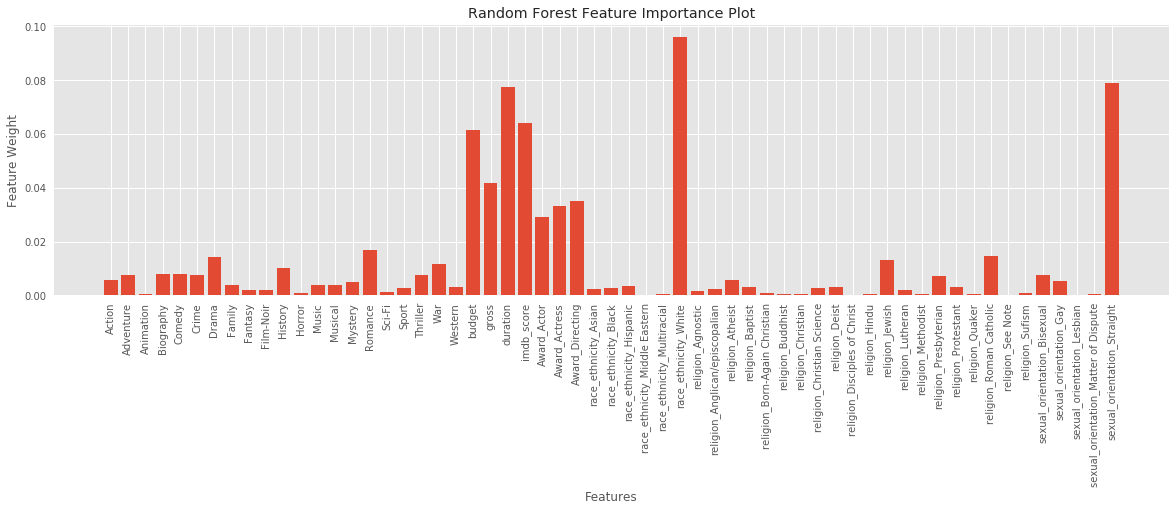

In [181]:
ignore_cols = ['race_ethnicity_Na', 'sexual_orientation_Na', 'religion_Na']
with plt.style.context(('seaborn', 'ggplot')):
    ## Creating dataframe of columns and their weights in model
    feature_importance = pd.DataFrame({'Columns': ml_df_one_hot.columns, 'Feature_Importance': rf.feature_importances_.flatten()})
    ## Removing Na values entries.
    feature_importance = feature_importance[~feature_importance.Columns.isin(ignore_cols)]
    
    plt.figure(figsize=(20,5))
    plt.bar(x=range(feature_importance.shape[0]), height=feature_importance['Feature_Importance'],)
    plt.xticks(range(feature_importance.shape[0]), feature_importance.Columns, rotation='vertical')
    plt.xlabel('Features')
    plt.ylabel('Feature Weight')
    plt.title('Random Forest Feature Importance Plot')

We can clearly see that there are list of attributes which contributed as winning factor for our model to be that accurate. The attributes who appear to weigh more significantly in our model are budget, gross, duration, imdb_score, award type, ethnicity white, sexual orientation straight, Romance, Drama, History, religion jewish, religion catholic etc.

### Ploting Performance of Non-White Winners Overtime

In [182]:
years, non_white_count, white_count = [], [], []
non_white_races = ['Asian', 'Black','Hispanic', 'Middle Eastern', 'Multiracial']

for year in winning_actors.year.unique():
    winning_actors_for_the_year = winning_actors[winning_actors.year == year]
    winning_actress_for_the_year = winning_actresses[winning_actresses.year == year]
    winning_directors_for_the_year = winning_directors[winning_directors.year == year]
    
    non_white_actors = winning_actors_for_the_year[winning_actors_for_the_year.race_ethnicity.isin(non_white_races)]
    white_actors = winning_actors_for_the_year[winning_actors_for_the_year.race_ethnicity == 'White']
    
    non_white_actress = winning_actress_for_the_year[winning_actress_for_the_year.race_ethnicity.isin(non_white_races)]
    white_actress = winning_actress_for_the_year[winning_actress_for_the_year.race_ethnicity == 'White']
    
    non_white_directors = winning_directors_for_the_year[winning_directors_for_the_year.race_ethnicity.isin(non_white_races)]
    white_directors = winning_directors_for_the_year[winning_directors_for_the_year.race_ethnicity == 'White']
    
    
    years.append(year)
    non_white_count.append(non_white_actors.shape[0]+non_white_actress.shape[0]+non_white_directors.shape[0])
    white_count.append(white_actors.shape[0]+white_actress.shape[0]+white_directors.shape[0])

fig = go.Figure()
fig.add_trace(go.Scatter(x=years, y=non_white_count, 
                         name='Non-White Winners Count Over the years',
                         mode='lines+markers',
                         connectgaps=True,
                         line=dict(color='firebrick', width=3)))

fig.add_trace(go.Scatter(x=years, y=white_count, 
                         name='White Winners Count Over the years',
                         mode='lines+markers',
                         connectgaps=True,
                         line=dict(color='green', width=3)))

fig.update_layout(title="Comparison of White vs Non-White Winners over time",xaxis_title="Years",yaxis_title="Winners Count")

fig.show()

From above graph, we can see that performance of non-white winner was quite low till 2000. After 2000 it seems to have improved.We have ignored entries where we had race data not available.That might be reason 2014 has 0 for both white and non-white because

**Note:** We have ignored entries where race data was not present.also 2014 has race data not available.

## 2. Do IMDB ratings ( audience taste) agree with the academy members opinion?


### Plotting Movies IMBD Rating For Winning Movies

In [183]:
fig = go.Figure(data=go.Scatter(x=winning_movies.year,
                                y=winning_movies.rating,
                                mode='markers',
                                marker_color=winning_movies.rating,
                                marker=dict(size=winning_movies.rating, showscale=True),
                                text=winning_movies.name)) # hover text goes here

fig.update_layout(title="Winning Movies Rating Over Time",xaxis_title="Years",yaxis_title="IMDB Rating")
fig.show()

We can say that on average oscar winning movies has quite hight rating with average quite reguraly more than 7. It helps us deduce that movie with more than 7 rating have higher chances of winning award.

## 3. Does budget necessarily play an important role?


### Plotting Winning Movies Budgets

In [184]:
fig = go.Figure(data=go.Scatter(x=winning_movies.year,
                                y=winning_movies.budget,
                                mode='markers',
                                marker_color=winning_movies.budget,
                                marker=dict(showscale=True),
                                text=winning_movies.name)) # hover text goes here

fig.update_layout(title='')
fig.update_layout(title="Winning Movies Budget Over Time",xaxis_title="Years",yaxis_title="Movie Budget")
fig.show()

In [185]:
## We can see from above the graph that overall budget seems to increase after 1995 with few movies exceeding 50M but also movies with budget less than 50M are also perfoming well.
## and below you see how much a total of 5000 movies in our imdb data set has spent on production and budget in general
## higher budget spending not neccessarily translates into academy award winning
fig = go.Figure(data=go.Scatter(x=metadata.title_year,
                                y=metadata.budget,
                                mode='markers',
                                marker_color=metadata.budget,
                                marker=dict(showscale=True),
                                text=metadata.movie_title)) # hover text goes here

fig.update_layout(title='')
fig.update_layout(title="Movies Budget Over Time",xaxis_title="Years",yaxis_title="Movie Budget")
fig.show()



## 4. Does diversity or lack of diversity of cast and crew in terms of race, gender, sexual orientation, etc. show a pattern of some sort? 


### Plotting Individual Race Counts

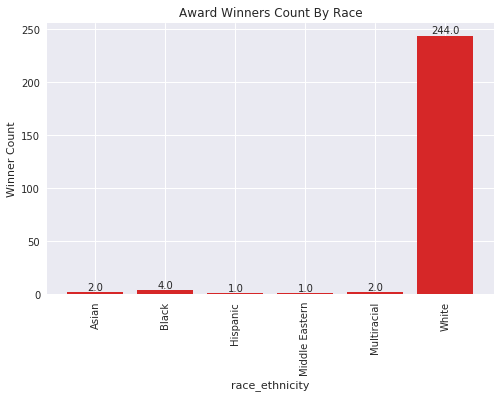

In [186]:
with plt.style.context(('ggplot', 'seaborn')):
    race_ethnicity = []
    for df in [winning_actors, winning_actresses, winning_directors]:
         race_ethnicity.append(pd.get_dummies(df[['race_ethnicity']]))
            
    race_ethnicity = pd.concat(race_ethnicity)
    ## Please ignore Na as its for rows where data was not present.
    cols = race_ethnicity.columns.tolist()
    #cols.remove('race_ethnicity_Na')
    race_ethnicity = race_ethnicity[cols]
    race_counts = race_ethnicity.sum(axis=0)

    plt.figure(figsize=(8,5))
    plt.bar(x=range(len(cols)), height=race_counts, color='tab:red')
    plt.xticks(range(len(cols)), [val.replace('race_ethnicity_','') for val in cols], rotation='vertical')
    plt.xlabel('race_ethnicity')
    plt.ylabel('Winner Count')
    plt.title('Award Winners Count By Race')
    
    for i in range(len(race_counts)):
        if race_counts[i] >= 0:
            plt.text(i, race_counts[i], '%.1f'%race_counts[i], horizontalalignment='center', verticalalignment='bottom')
        else:
            plt.text(i, race_counts[i], '%.1f'%race_counts[i], horizontalalignment='center', verticalalignment='top')

We can see that ethnicity white resulted in a meaningful higher count of award winning . Majority of oscar winners are white after that hispanic, black, middle eastern, multiracial and asian in that order. We don't neccessarily see non-white representation among academy award winners.

### Plotting Individual Religion Count

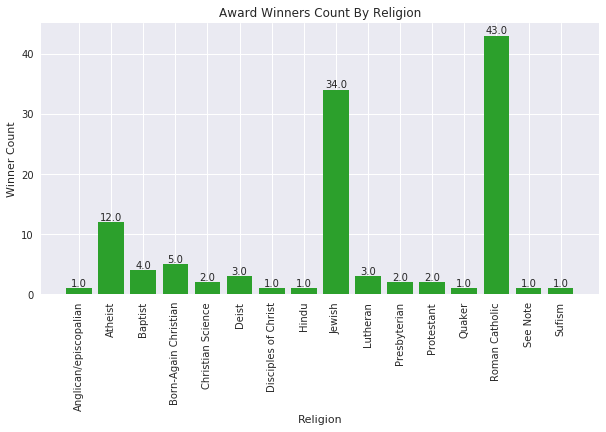

In [187]:
with plt.style.context(('ggplot', 'seaborn')):
    religion = []
    for df in [winning_actors, winning_actresses, winning_directors]:
         religion.append(pd.get_dummies(df[['religion']]))
            
    religion = pd.concat(religion)
    ## Please ignore Na as its for rows where data was not present.
    cols = religion.columns.tolist()
    cols.remove('religion_Na')
    religion = religion[cols]
    religion_counts = religion.sum(axis=0)

    plt.figure(figsize=(10,5))
    plt.bar(x=range(len(cols)), height=religion_counts, color='tab:green')
    plt.xticks(range(len(cols)), [val.replace('religion_','') for val in cols], rotation='vertical')
    plt.xlabel('Religion')
    plt.ylabel('Winner Count')
    plt.title('Award Winners Count By Religion')
    
    for i in range(len(religion_counts)):
        if religion_counts[i] >= 0:
            plt.text(i, religion_counts[i], '%.1f'%religion_counts[i], horizontalalignment='center', verticalalignment='bottom')
        else:
            plt.text(i, religion_counts[i], '%.1f'%religion_counts[i], horizontalalignment='center', verticalalignment='top')

Chart above shows religion distribution of academy awards winners, with Roman Catholics, Jews, and Atheists, leading the numbers.


### Plotting Individual Sexual Orientation Count

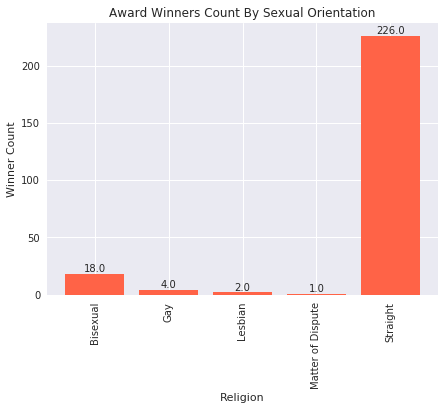

In [188]:
with plt.style.context(('ggplot', 'seaborn')):
    sexual_orientation = []
    for df in [winning_actors, winning_actresses, winning_directors]:
         sexual_orientation.append(pd.get_dummies(df[['sexual_orientation']]))
    sexual_orientation = pd.concat(sexual_orientation)
    ## Please ignore Na as its for rows where data was not present.
    cols = sexual_orientation.columns.tolist()
    cols.remove('sexual_orientation_Na')
    sexual_orientation = sexual_orientation[cols]
    sexual_orientation_counts = sexual_orientation.sum(axis=0)

    plt.figure(figsize=(7,5))
    plt.bar(x=range(len(cols)), height=sexual_orientation_counts, color='tomato')
    plt.xticks(range(len(cols)), [val.replace('sexual_orientation_','') for val in cols], rotation='vertical')
    plt.xlabel('Religion')
    plt.ylabel('Winner Count')
    plt.title('Award Winners Count By Sexual Orientation')
    
    for i in range(len(sexual_orientation_counts)):
        if sexual_orientation_counts[i] >= 0:
            plt.text(i, sexual_orientation_counts[i], '%.1f'%sexual_orientation_counts[i], horizontalalignment='center', verticalalignment='bottom')
        else:
            plt.text(i, sexual_orientation_counts[i], '%.1f'%sexual_orientation_counts[i], horizontalalignment='center', verticalalignment='top')

We do see a better chance in winning when the nominee appeared to be straight, and after that bisexuals had a higher chance. Lower numbers in Gay, Lesbian communities would need some attention. 


### We have to be careful interpretting all the data above, that might not necessarily show bias in the awarding system, it could be rooted in hiring and recruiting process, which needs further studies on it.

## 5. What movie genre and categories are more likely to win the award

### Plotting Individual Genres Count

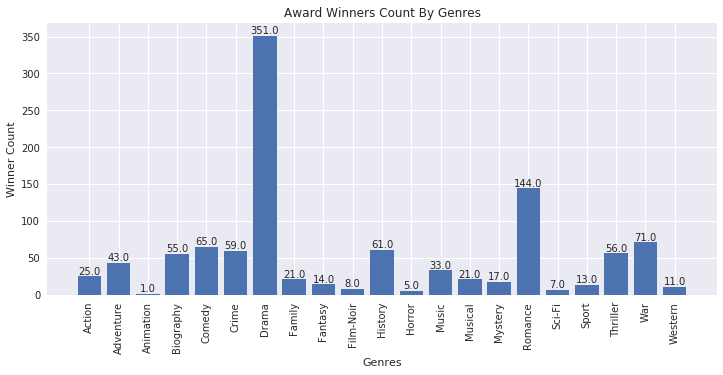

In [189]:
with plt.style.context(('ggplot', 'seaborn')):
    plt.figure(figsize=(12,5))

    genre_counts = ml_df[genres_cols].sum(axis=0)
    plt.bar(x=range(len(genre_counts)), height=genre_counts)
    plt.xticks(range(len(genre_counts)), ml_df[genres_cols].columns, rotation='vertical')
    plt.xlabel('Genres')
    plt.ylabel('Winner Count')
    plt.title('Award Winners Count By Genres')
    
    for i in range(len(genre_counts)):
        if genre_counts[i] >= 0:
            plt.text(i, genre_counts[i], '%.1f'%genre_counts[i], horizontalalignment='center', verticalalignment='bottom')
        else:
            plt.text(i, genre_counts[i], '%.1f'%v[i], horizontalalignment='center', verticalalignment='top')

Above relation between genres of movies and winner of awards shows that Drama movies has highest chance of winning awards. After that History, War, Adventure and Crime has also quite good chance of winning awards.

## Further Stats - Some Fun Facts
Below are further list of stats about winning actors, winning actresses, directors and movies.

### Winning Actors Stats

In [190]:
print('Average Nominations for Winning Actors : %.2f'%np.mean([int(nom) for nom in winning_actors['nominations'] if nom.isdigit()]))
print('\nAverage Movie Duration for Winning Actors : %.2f'%winning_actors.duration.mean())

genres = Counter(winning_actors['genre1'].values.tolist()+winning_actors['genre2'].values.tolist())
sorted_genres = list(sorted(genres.items(), key=lambda x: x[1], reverse=True))
print('\nTop 5 Genre for Winning Actors : %s'%sorted_genres[:5])

print('\nAverage Metacritic Ratings for Winning Actors : %.2f'%winning_actors.metacritic.mean())
print('\nAverage Budget of Movies for Winning Actors : %.2f'%winning_actors.budget.mean())
print('\nAverage Gross Income of Movies for Winning Actors : %.2f'%winning_actors.gross.mean())
locations = Counter([loc.split(',')[-1].strip() for loc in winning_actors.birthplace if isinstance(loc, str)])
sorted_locations = list(sorted(locations.items(), key=lambda x: x[1], reverse=True))
print('\nTop 5 BirthPlaces for Winning Actors : %s'%sorted_locations[:5])
print('\nRace Ethnicity Distribution of Winning Actors : %s'%Counter(winning_actors.race_ethnicity))
print('\nSexual Orientation Distribution of Winning Actors : %s'%Counter(winning_actors.sexual_orientation))
print('\nReligion Distribution of Winning Actors %s'%Counter(winning_actors.religion))

actor_to_oscars_cnt = sorted(Counter(winning_actors['person']).items(), key=lambda x: x[1], reverse=True)
print('\nActors who Won Oscars more than Once : %s'%[val for val in actor_to_oscars_cnt if val[1]>1 and isinstance(val[0], str)])

Average Nominations for Winning Actors : 6.90

Average Movie Duration for Winning Actors : 124.12

Top 5 Genre for Winning Actors : [('Drama', 84), ('Biography', 24), (nan, 18), ('Romance', 13), ('Crime', 12)]

Average Metacritic Ratings for Winning Actors : 80.93

Average Budget of Movies for Winning Actors : 20861250.00

Average Gross Income of Movies for Winning Actors : 72338547.24

Top 5 BirthPlaces for Winning Actors : [('England', 16), ('Ca', 13), ('Ny', 7), ('New York City', 6), ('Tx', 3)]

Race Ethnicity Distribution of Winning Actors : Counter({'White': 72, nan: 14, 'Black': 4, 'Middle Eastern': 1, 'Multiracial': 1, 'Hispanic': 1})

Sexual Orientation Distribution of Winning Actors : Counter({'Straight': 71, nan: 14, 'Bisexual': 6, 'Matter of Dispute': 1, 'Gay': 1})

Religion Distribution of Winning Actors Counter({'Na': 38, 'Roman Catholic': 19, nan: 14, 'Jewish': 6, 'Lutheran': 3, 'Born-Again Christian': 3, 'Deist': 3, 'Protestant': 2, 'Baptist': 1, 'Quaker': 1, 'Atheist': 

### Winning Actress Stats

In [191]:
print('Average Nominations for Winning Actresses : %.2f'%np.mean([int(nom) for nom in winning_actresses['nominations'] if str(nom).isdigit()]))
print('\nAverage Movie Duration for Winning Actresses : %.2f'%winning_actresses.duration.mean())

genres = Counter(winning_actresses['genre1'].values.tolist()+winning_actresses['genre2'].values.tolist())
sorted_genres = list(sorted(genres.items(), key=lambda x: x[1], reverse=True))
print('\nTop 5 Genre for Winning Actresses : %s'%sorted_genres[:5])

print('\nAverage Metacritic Ratings for Winning Actresses : %.2f'%winning_actresses.metacritic.mean())
print('\nAverage Budget of Movies for Winning Actresses : %.2f'%winning_actresses.budget.mean())
print('\nAverage Gross Income of Movies for Winning Actresses : %.2f'%winning_actresses.gross.mean())
locations = Counter([loc.split(',')[-1].strip() for loc in winning_actresses.birthplace if isinstance(loc, str)])
sorted_locations = list(sorted(locations.items(), key=lambda x: x[1], reverse=True))
print('\nTop 5 BirthPlaces for Winning Actresses : %s'%sorted_locations[:5])
print('\nRace Ethnicity Distribution of Winning Actresses : %s'%Counter(winning_actresses.race_ethnicity))
print('\nSexual Orientation Distribution of Winning Actresses : %s'%Counter(winning_actresses.sexual_orientation))
print('\nReligion Distribution of Winning Actresses %s'%Counter(winning_actresses.religion))

actress_to_oscars_cnt = sorted(Counter(winning_actresses['person']).items(), key=lambda x: x[1], reverse=True)
print('Actresses who Won Oscars more than Once : %s'%[val for val in actress_to_oscars_cnt if val[1]>1 and isinstance(val[0], str)])

Average Nominations for Winning Actresses : 6.53

Average Movie Duration for Winning Actresses : 115.97

Top 5 Genre for Winning Actresses : [('Drama', 84), ('Romance', 28), (nan, 21), ('Comedy', 16), ('Biography', 15)]

Average Metacritic Ratings for Winning Actresses : 77.48

Average Budget of Movies for Winning Actresses : 16891666.67

Average Gross Income of Movies for Winning Actresses : 74156171.35

Top 5 BirthPlaces for Winning Actresses : [('England', 13), ('Ca', 10), ('Ne', 4), ('Ga', 4), ('Ct', 4)]

Race Ethnicity Distribution of Winning Actresses : Counter({'White': 86, nan: 7, 'Multiracial': 1})

Sexual Orientation Distribution of Winning Actresses : Counter({'Straight': 77, nan: 7, 'Bisexual': 6, 'Na': 2, 'Lesbian': 2})

Religion Distribution of Winning Actresses Counter({'Na': 51, 'Roman Catholic': 12, 'Jewish': 9, nan: 7, 'Atheist': 7, 'Born-Again Christian': 2, 'Christian Science': 2, 'Hindu': 1, 'Disciples of Christ': 1, 'Baptist': 1, 'Sufism': 1})
Actresses who Won Os

### Winning Directors Stats

In [192]:
print('Average Nominations for Winning Directors : %.2f'%np.mean([int(nom) for nom in winning_directors['nominations'] if str(nom).isdigit()]))
print('\nAverage Movie Duration for Winning Directors : %.2f'%winning_directors.duration.mean())

genres = Counter(winning_directors['genre1'].values.tolist()+winning_directors['genre2'].values.tolist())
sorted_genres = list(sorted(genres.items(), key=lambda x: x[1], reverse=True))
print('\nTop 5 Genre for Winning Directors : %s'%sorted_genres[:5])

print('\nAverage Metacritic Ratings for Winning Directors : %.2f'%winning_directors.metacritic.mean())
print('\nAverage Budget of Movies for Winning Directors : %.2f'%winning_directors.budget.mean())
print('\nAverage Gross Income of Movies for Winning Directors : %.2f'%winning_directors.gross.mean())
locations = Counter([loc.split(',')[-1].strip() for loc in winning_directors.birthplace if isinstance(loc, str)])
sorted_locations = list(sorted(locations.items(), key=lambda x: x[1], reverse=True))
print('\nTop 5 BirthPlaces for Winning Directors : %s'%sorted_locations[:5])
print('\nRace Ethnicity Distribution of Winning Directors : %s'%Counter(winning_directors.race_ethnicity))
print('\nSexual Orientation Distribution of Winning Directors : %s'%Counter(winning_directors.sexual_orientation))
print('\nReligion Distribution of Winning Directors %s'%Counter(winning_directors.religion))

directors_to_oscars_cnt = sorted(Counter(winning_actresses['person']).items(), key=lambda x: x[1], reverse=True)
print('\nDirectors who Won Oscars more than Once : %s'%[val for val in directors_to_oscars_cnt if val[1]>1 and isinstance(val[0], str)])

Average Nominations for Winning Directors : 8.88

Average Movie Duration for Winning Directors : 138.77

Top 5 Genre for Winning Directors : [('Drama', 82), ('Romance', 18), ('Comedy', 17), ('Biography', 15), ('Crime', 12)]

Average Metacritic Ratings for Winning Directors : 84.11

Average Budget of Movies for Winning Directors : 26449179.10

Average Gross Income of Movies for Winning Directors : 118296036.45

Top 5 BirthPlaces for Winning Directors : [('England', 11), ('Ca', 9), ('France', 7), ('Il', 7), ('New York City', 6)]

Race Ethnicity Distribution of Winning Directors : Counter({'White': 86, nan: 7, 'Asian': 2})

Sexual Orientation Distribution of Winning Directors : Counter({'Straight': 78, nan: 7, 'Bisexual': 6, 'Gay': 3, 'Na': 1})

Religion Distribution of Winning Directors Counter({'Na': 49, 'Jewish': 19, 'Roman Catholic': 12, nan: 7, 'Atheist': 4, 'Baptist': 2, 'See Note': 1, 'Presbyterian': 1})

Directors who Won Oscars more than Once : [('Hilary Swank', 4), ('Katharine H

### Winning Movies Stats

In [193]:
print('Average Nominations for Winning Movies : %.2f'%np.mean([int(nom) for nom in winning_movies['nominations'] if str(nom).isdigit()]))
print('\nAverage Movie Duration for Winning Directors : %.2f'%winning_directors.duration.mean())

genres = Counter(winning_movies['genre1'].values.tolist()+winning_movies['genre2'].values.tolist())
sorted_genres = list(sorted(genres.items(), key=lambda x: x[1], reverse=True))
print('\nTop 5 Genre for Winning Directors : %s'%sorted_genres[:5])

print('\nAverage Metacritic Ratings for Winning Directors : %.2f'%winning_movies.metacritic.mean())
print('\nAverage Budget of Movies for Winning Directors : %.2f'%winning_movies.budget.mean())
print('\nAverage Gross Income of Movies for Winning Directors : %.2f'%winning_movies.gross.mean())

Average Nominations for Winning Movies : 9.14

Average Movie Duration for Winning Directors : 138.77

Top 5 Genre for Winning Directors : [('Drama', 79), ('Romance', 18), ('Comedy', 17), ('Biography', 17), ('Crime', 12)]

Average Metacritic Ratings for Winning Directors : 83.69

Average Budget of Movies for Winning Directors : 25809194.44

Average Gross Income of Movies for Winning Directors : 102579933.13
